# Deel 1) Imports

In dit deel importen we alle nodige packages

In [38]:
# importing the Keras libraries and packages
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import layers, Model

# Import matplotlib & numpy
import matplotlib.pyplot as plt
import numpy as np

# Deel 2) Model bouwen

In dit deel creeren we het effectieve model met al haar layers.
We definieren input en output layers, maar ook tussenlayers.

In [39]:
global model_GAP
# Constants
NUM_CLASSES = 5
IMG_SIZE = 64

# Define the input layer
inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# Add a resizing layer to resize the images to a consistent shape
x = layers.Resizing(IMG_SIZE, IMG_SIZE)(inputs)
# Add a rescaling layer to rescale the pixel values to the [0, 1] range
x = layers.Rescaling(1./255)(x)
# Add some data augmentation layers to apply random transformations during training
x = layers.RandomFlip("horizontal")(x)
# Uncomment the following line if RandomShear is needed
# x = layers.RandomShear(0.2)(x)
x = layers.RandomZoom(0.2)(x)

# Add the convolutional and pooling layers
x = layers.Conv2D(32, (3, 3), activation="relu")(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.2)(x)
x = layers.Conv2D(32, (3, 3), activation="relu")(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.2)(x)

# Flatten the output of the convolutional layers
x = layers.Flatten()(x)
# x = layers.GlobalAveragePooling2D()(x)

# Add the dense layers
x = layers.Dense(128, activation="relu")(x)
# SOFT_MAX ALS ACTIVATION
outputs = layers.Dense(NUM_CLASSES, activation="sigmoid")(x)

# Create the model
model_GAP = Model(inputs=inputs, outputs=outputs, name="base_model_project")

# Compile the model
model_GAP.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model_GAP.summary()



Model: "base_model_project"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing_1 (Resizing)           │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_1 (RandomFlip)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_1 (RandomZoom)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 29, 29, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       802,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 813,733 (3.10 MB)

 Trainable params: 813,733 (3.10 MB)

 Non-trainable params: 0 (0.00 B)

In bovenstaande tabel vinden we alle layers van ons netwerk. In de input_layer merken we dat de output shape 64 bij 64 is. Aangezien we onze images in die size aan het model geven.
De output is in een dimensie van 5 mogelijkheden. Dit zijn onze katten, cheetas, enz.

# 3) Model trainen

In volgende stap gaan we het model trainen met de training data die we hebben.

## 3.1) Training en validation data laden

Allereerst splitsen we onze data in trainingdata en in validation data. Dit in een 70-30 splitsing. de validation data wordt niet gebruikt om het model te trainen. Maar hiermee kunnen we wel verifieren hoe goed ons model ongeveer is.
Later zullen we de resultaten van de trainingdata vergelijken met de validation data, hiermee kunnen we overfitting opsporen.

In [40]:
# Set the parameters for your data
batch_size = 32
image_size = (64, 64)
validation_split = 0.3

# Create the training dataset from the 'train' directory
train_ds = image_dataset_from_directory(
    directory='./train/train',
    labels='inferred',
    label_mode='categorical',
    batch_size=batch_size,
    image_size=image_size,
    validation_split=validation_split,
    subset='training',
    seed=123
)

# Create the validation dataset from the 'train' directory
validation_ds = image_dataset_from_directory(
    directory='./train/train',
    labels='inferred',
    label_mode='categorical',
    batch_size=batch_size,
    image_size=image_size,
    validation_split=validation_split,
    subset='validation',
    seed=123
)

# Ensure the dataset can generate enough batches (so keep on generating when needed)
train_ds = train_ds.repeat()
validation_ds = validation_ds.repeat()

Found 2026 files belonging to 5 classes.
Using 1419 files for training.
Found 2026 files belonging to 5 classes.
Using 607 files for validation.


## 3.2) Model trainen

We gaan nu het model effectief trainen. Dit kan lang duren afhankelijk van je CPU of grafische kaart.

In [41]:
history = model_GAP.fit(train_ds,
    validation_data = validation_ds,
    steps_per_epoch = 100,
    validation_steps = 30, # we have a .30 validation split, so we'll use 70% less batches for validation
    epochs = 20 # Na testing is dit de beste epoch vooraleer er overfitting optreedt
    )

Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - accuracy: 0.2857 - loss: 1.6431 - val_accuracy: 0.4390 - val_loss: 1.3700
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.4542 - loss: 1.3365 - val_accuracy: 0.4008 - val_loss: 1.5076
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.5362 - loss: 1.1887 - val_accuracy: 0.5287 - val_loss: 1.2608
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.6115 - loss: 1.0334 - val_accuracy: 0.5616 - val_loss: 1.1624
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.6654 - loss: 0.8567 - val_accuracy: 0.6038 - val_loss: 1.1990
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.7243 - loss: 0.7404 - val_accuracy: 0.5240 - val_loss: 1.4810
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.7709 - loss: 0.6751 - val_accuracy: 0.6420 - val_loss: 1.0969
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.7922 - loss: 0.5904 - val_accu

In onderstaande grafiek bekijken we de resultaten nog eens van de training loss per epoch

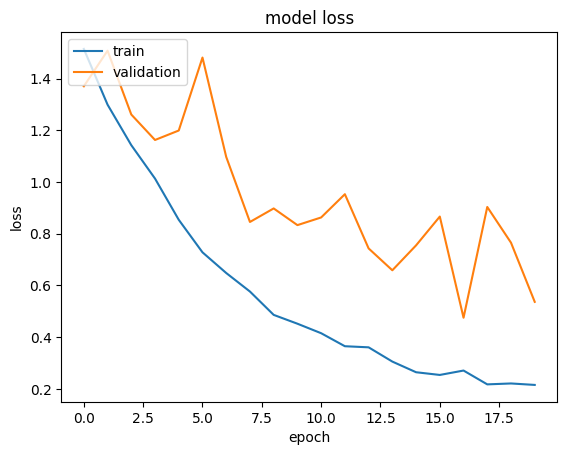

In [42]:
def plotLosses(history):  
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

plotLosses(history)

# 4) Predictions maken

In dit deel gaan we predictions maken op images die we nog nooit eerder gezien hebben.
We gaan bekijken welk soort katachtige het is.

In [43]:
# Prediction functie
def predict(img_num: int) -> tuple[str, int]:
    """
    #Return: tuple met string[naam katachtige] en int[type katachtige]
    #Args: img_num[number of image in test]
    """
    rel_path = f"./test/test/{img_num}.jpg"
    test_image =image.load_img(path=rel_path, target_size = (64, 64))
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis = 0)
    result = model_GAP.predict(test_image)

    max_result = np.argmax(result) # Neemt de hoogste probability van de resultaten
    if max_result == 0: return ('cat', 0)
    elif max_result == 1: return ('cheetah', 1)
    elif max_result == 2: return ('leopard', 2)
    elif max_result == 3: return ('lion', 3)
    return ('tiger', 4)


In [44]:
"""
Er zijn 473 images die gepridict moeten worden.
dit doen we met een list comprehension.
"""
results = [[i, predict(i)[1]] for i in range(1,474)]
results

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━

[[1, 0],
 [2, 4],
 [3, 2],
 [4, 1],
 [5, 0],
 [6, 3],
 [7, 2],
 [8, 4],
 [9, 3],
 [10, 1],
 [11, 0],
 [12, 4],
 [13, 2],
 [14, 3],
 [15, 2],
 [16, 3],
 [17, 4],
 [18, 0],
 [19, 4],
 [20, 1],
 [21, 2],
 [22, 4],
 [23, 3],
 [24, 0],
 [25, 2],
 [26, 2],
 [27, 1],
 [28, 2],
 [29, 2],
 [30, 2],
 [31, 0],
 [32, 1],
 [33, 1],
 [34, 4],
 [35, 4],
 [36, 0],
 [37, 2],
 [38, 4],
 [39, 2],
 [40, 2],
 [41, 0],
 [42, 3],
 [43, 1],
 [44, 0],
 [45, 1],
 [46, 2],
 [47, 1],
 [48, 3],
 [49, 4],
 [50, 2],
 [51, 0],
 [52, 3],
 [53, 1],
 [54, 2],
 [55, 3],
 [56, 2],
 [57, 0],
 [58, 1],
 [59, 0],
 [60, 1],
 [61, 2],
 [62, 1],
 [63, 1],
 [64, 2],
 [65, 1],
 [66, 4],
 [67, 2],
 [68, 2],
 [69, 1],
 [70, 4],
 [71, 1],
 [72, 4],
 [73, 4],
 [74, 3],
 [75, 2],
 [76, 1],
 [77, 0],
 [78, 1],
 [79, 2],
 [80, 3],
 [81, 3],
 [82, 1],
 [83, 4],
 [84, 1],
 [85, 1],
 [86, 2],
 [87, 0],
 [88, 2],
 [89, 1],
 [90, 1],
 [91, 3],
 [92, 1],
 [93, 1],
 [94, 3],
 [95, 1],
 [96, 3],
 [97, 2],
 [98, 0],
 [99, 2],
 [100, 0],
 [101, 2

Nu moeten we de resultaten nog in een csv zetten.

In [45]:
import csv

# Specify the file name
filename = "result.csv"

# Write data to CSV file
with open(filename, 'w', newline='') as csvfile:
    # Create a CSV writer object
    csvwriter = csv.writer(csvfile)
    
    # Write the headers
    csvwriter.writerow(['id', 'result'])
    
    # Write the data rows
    csvwriter.writerows(results)

print("CSV file has been created successfully!")

CSV file has been created successfully!
